# Lab 1: Pengantar TensorFlow dan Generasi Musik dengan RNN

# Bagian 2: Generasi Musik dengan RNN

Pada bagian lab ini, kita akan mengeksplorasi pembangunan Recurrent Neural Network (RNN) untuk generasi musik. Kita akan melatih sebuah model agar dapat mempelajari pola-pola dalam lembaran musik mentah menggunakan [notasi ABC](https://en.wikipedia.org/wiki/ABC_notation), lalu menggunakan model ini untuk menghasilkan musik baru.


## 2.1 Dependensi
Pertama, mari kita unduh repository kursus, pasang dependensi, dan impor paket-paket yang relevan yang akan kita gunakan dalam lab ini.

Kita akan menggunakan [Comet ML](https://www.comet.com/docs/v2/) untuk melacak pengembangan model dan proses pelatihan.  
Langkah pertama, daftar akun Comet melalui [tautan ini](https://www.comet.com/signup?utm_source=mit_dl&utm_medium=partner&utm_content=github) (kamu bisa menggunakan akun Google atau Github).  

Setelah itu, kamu akan mendapatkan **API Key pribadi**, yang bisa ditemukan di:
- halaman pertama **Get Started with Comet**,  
- pengaturan akun, atau  
- dengan menekan tombol `?` di pojok kanan atas lalu memilih **Quickstart Guide**.  

Masukkan API key ini sebagai variabel global `COMET_API_KEY`.


In [ ]:
# !pip install comet_ml 
# > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "API COMET KALIAN" # TODO (5)

# Import Tensorflow 2.0
import tensorflow as tf

# Download and import the MIT Introduction to Deep Learning package
!pip install setuptools==65.5.0 packaging==21.3
!pip install mitdeeplearning 
# !pip install git+https://github.com/aamini/introtodeeplearning.git

import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
# assert len(tf.config.list_physical_devices('GPU')) > 0
# assert COMET_API_KEY != "", "Please insert your Comet API Key"

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## 2.2 Dataset

Kita telah mengumpulkan sebuah dataset yang berisi ribuan lagu rakyat Irlandia, yang dituliskan dalam notasi ABC.  
Mari kita unduh dataset tersebut dan memeriksanya lebih lanjut:


In [10]:
# Unduh dataset lagu dalam format notasi ABC
songs = mdl.lab1.load_training_data()

# Ambil salah satu contoh lagu dari dataset untuk diperiksa lebih detail
example_song = songs[0]
print("\nContoh lagu: ")
print(example_song)

Found 817 songs in text

Contoh lagu: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


Kita dapat dengan mudah mengonversi sebuah lagu dalam notasi ABC menjadi bentuk gelombang audio dan memutarnya kembali. Harap bersabar saat proses konversi berlangsung, karena dapat memerlukan waktu tertentu.

In [11]:
# Konversi lagu dari notasi ABC ke file audio, lalu mainkan hasilnya
mdl.lab1.play_song(example_song)

Satu hal penting yang perlu dipikirkan adalah bahwa notasi musik ini tidak hanya berisi informasi tentang nada yang dimainkan, tetapi juga memiliki **meta-informasi** seperti judul lagu, kunci (key), dan tempo.  

Bagaimana jumlah karakter berbeda yang muncul dalam file teks memengaruhi tingkat kompleksitas masalah pembelajaran?  
Hal ini akan menjadi penting nantinya, ketika kita membuat representasi numerik untuk data teks tersebut.


In [12]:
# Gabungkan semua lagu menjadi satu string besar (dipisahkan dengan newline ganda)
songs_joined = "\n\n".join(songs)

# Cari semua karakter unik yang muncul di seluruh dataset (vocabulary)
vocab = sorted(set(songs_joined))
print("Jumlah karakter unik dalam dataset:", len(vocab))

Jumlah karakter unik dalam dataset: 83


## 2.3 Pemrosesan Dataset untuk Tugas Pembelajaran

Mari kita mundur sedikit dan pikirkan tentang tugas prediksi kita.  
Kita ingin melatih model RNN untuk mempelajari pola dalam musik ABC, lalu menggunakan model ini untuk menghasilkan (memprediksi) potongan musik baru berdasarkan informasi yang telah dipelajari.

Jika diuraikan, pertanyaan yang kita ajukan ke model adalah:  
dengan diberikan sebuah karakter, atau urutan karakter, karakter apa yang paling mungkin muncul berikutnya?  
Kita akan melatih model untuk melakukan tugas ini.

Untuk mencapainya, kita akan memasukkan sebuah urutan karakter ke dalam model, lalu melatih model agar mampu memprediksi keluaran, yaitu karakter berikutnya di setiap langkah waktu.  
RNN menyimpan **state internal** yang bergantung pada elemen-elemen sebelumnya, sehingga informasi dari semua karakter yang sudah dilihat hingga suatu titik waktu tertentu akan dipertimbangkan dalam menghasilkan prediksi.

### Vektorisasi Teks

Sebelum kita mulai melatih model RNN, kita perlu membuat representasi numerik dari dataset berbasis teks kita.  
Untuk melakukan ini, kita akan membuat dua tabel pencarian (*lookup tables*):  
1. tabel yang memetakan karakter ke angka, dan  
2. tabel yang memetakan angka kembali ke karakter.  

Ingat bahwa sebelumnya kita sudah mengidentifikasi karakter-karakter unik yang ada di dalam teks.

In [13]:
### Definisikan representasi numerik dari teks ###

# Buat mapping dari karakter → indeks unik.
# Contoh: untuk mendapatkan indeks dari karakter "d",
#   gunakan `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Buat mapping dari indeks → karakter (kebalikan dari char2idx).
# Ini berguna untuk mengonversi kembali dari angka ke karakter.
idx2char = np.array(vocab)

Ini memberikan kita representasi integer untuk setiap karakter.  
Perhatikan bahwa karakter-karakter unik (yaitu *vocabulary* kita) pada teks dipetakan sebagai indeks dari 0 hingga `len(unique)`.  

Sekarang, mari kita lihat sekilas representasi numerik dari dataset kita:

In [14]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [15]:
### Vektorisasi string lagu ###

# Fungsi untuk mengonversi string lagu (berisi karakter notasi ABC)
# menjadi representasi numerik. 
# Setiap karakter dipetakan ke indeks unik menggunakan char2idx.
# Output: np.array dengan panjang N, 
#   di mana N = jumlah karakter dalam string input.
def vectorize_string(string):
    vectorized_output = np.array([char2idx[char] for char in string])
    return vectorized_output

# Contoh: vektorisasi semua lagu yang sudah digabung
vectorized_songs = vectorize_string(songs_joined)

Kita juga dapat melihat bagaimana bagian awal dari teks dipetakan ke dalam representasi integer:

In [16]:
# Cetak 10 karakter pertama dari dataset beserta representasi angkanya
print('{} ---- karakter dipetakan ke angka ----> {}'.format(
    repr(songs_joined[:10]), vectorized_songs[:10]
))

# Pastikan hasil vektorisasi berupa numpy array
assert isinstance(vectorized_songs, np.ndarray), "Hasil yang dikembalikan harus berupa numpy array"

'X:1\nT:Alex' ---- karakter dipetakan ke angka ----> [49 22 13  0 45 22 26 67 60 79]


### Membuat Contoh Latihan dan Target

Langkah selanjutnya adalah membagi teks menjadi **urutan contoh** yang akan digunakan selama pelatihan.  
Setiap urutan input yang dimasukkan ke dalam RNN akan berisi `seq_length` karakter dari teks.  
Kita juga perlu mendefinisikan urutan target untuk setiap input, yang akan digunakan untuk melatih RNN agar mampu memprediksi karakter berikutnya.  

Untuk setiap input, target yang sesuai akan memiliki panjang teks yang sama, tetapi digeser satu karakter ke kanan.  

Caranya adalah dengan membagi teks menjadi potongan (*chunks*) sepanjang `seq_length+1`.  
Misalnya, jika `seq_length = 4` dan teks kita adalah `"Hello"`, maka:  
- urutan input = `"Hell"`  
- urutan target = `"ello"`  

Metode *batch* kemudian memungkinkan kita untuk mengonversi aliran indeks karakter ini menjadi urutan-urutan dengan ukuran yang diinginkan.

In [17]:
### Definisi fungsi batch untuk membuat contoh latihan ###

def get_batch(vectorized_songs, seq_length, batch_size):
    # Panjang total data (dikurangi 1 karena target digeser 1 langkah)
    n = vectorized_songs.shape[0] - 1

    # Pilih indeks awal secara acak untuk setiap contoh dalam batch
    idx = np.random.choice(n - seq_length, batch_size)

    # Buat daftar input sequence untuk batch (masing-masing sepanjang seq_length)
    input_batch = [vectorized_songs[i : i + seq_length] for i in idx]

    # Buat daftar target sequence (digeser 1 karakter ke kanan)
    output_batch = [vectorized_songs[i + 1 : i + seq_length + 1] for i in idx]

    # Bentuk akhir x_batch dan y_batch agar sesuai untuk training
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    return x_batch, y_batch


# Uji fungsi batch dengan argumen sederhana
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] Fungsi batch tidak lolos pengujian")
else:
   print("======\n[PASS] Fungsi batch berhasil lolos semua pengujian!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] Fungsi batch berhasil lolos semua pengujian!


Untuk setiap vektor, setiap indeks diproses pada satu langkah waktu (*time step*).  
Jadi, pada input di *time step* ke-0, model menerima indeks dari karakter pertama dalam urutan, lalu mencoba memprediksi indeks karakter berikutnya.  

Pada *time step* berikutnya, model melakukan hal yang sama, tetapi RNN juga mempertimbangkan informasi dari langkah sebelumnya, yaitu **state** yang telah diperbarui, selain input saat ini.  

Kita bisa membuat ini lebih konkret dengan melihat bagaimana proses ini bekerja pada beberapa karakter pertama dalam teks kita:

In [18]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 60 (np.str_('e'))
  expected output: 59 (np.str_('d'))
Step   1
  input: 59 (np.str_('d'))
  expected output: 1 (np.str_(' '))
Step   2
  input: 1 (np.str_(' '))
  expected output: 61 (np.str_('f'))
Step   3
  input: 61 (np.str_('f'))
  expected output: 56 (np.str_('a'))
Step   4
  input: 56 (np.str_('a'))
  expected output: 61 (np.str_('f'))


## 2.4 Model Recurrent Neural Network (RNN)

Sekarang kita siap untuk mendefinisikan dan melatih model RNN pada dataset musik ABC kita, lalu menggunakan model terlatih tersebut untuk menghasilkan lagu baru.  
Kita akan melatih RNN menggunakan *batch* potongan lagu dari dataset, yang sudah kita buat pada bagian sebelumnya.

Model ini berbasis pada arsitektur **LSTM**, di mana kita menggunakan sebuah **state vector** untuk menyimpan informasi tentang hubungan temporal antar karakter berurutan.  
Output akhir dari LSTM kemudian dimasukkan ke dalam lapisan terhubung penuh ([`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)), yang menghasilkan distribusi *softmax* atas setiap karakter dalam *vocabulary*. Dari distribusi ini, kita dapat melakukan *sampling* untuk memprediksi karakter berikutnya.

Seperti yang sudah diperkenalkan di bagian pertama lab ini, kita akan menggunakan **Keras API**, khususnya [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), untuk mendefinisikan model.  
Model ini terdiri dari tiga lapisan utama:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): Lapisan input berupa tabel pencarian yang dapat dilatih (*trainable lookup table*), memetakan setiap karakter (dalam bentuk angka) ke vektor dengan dimensi `embedding_dim`.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Jaringan LSTM dengan ukuran `units=rnn_units`.
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): Lapisan output dengan jumlah neuron = `vocab_size`, menghasilkan prediksi untuk setiap karakter.

<img src="https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Ilustrasi LSTM"/>


### Mendefinisikan Model RNN

Sekarang, kita akan membuat sebuah fungsi yang akan digunakan untuk membangun model tersebut.

In [19]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

Sudah tiba saatnya! Lengkapi bagian `TODOs` untuk mendefinisikan model RNN di dalam fungsi `build_model`, kemudian panggil fungsi yang baru saja Anda definisikan tersebut untuk membuat instance model!

In [ ]:
### Mendefinisikan Model RNN ###

'''Tambahkan layer LSTM dan Dense untuk mendefinisikan model RNN menggunakan Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer untuk mengubah indeks menjadi vektor padat
    #   dengan ukuran embedding yang tetap
    tf.keras.layers.Embedding(vocab_size, embedding_dim),

    # Layer 2: LSTM dengan jumlah unit sebanyak `rnn_units`.
    # TODO: Panggil fungsi LSTM yang telah didefinisikan di atas untuk menambahkan layer ini. (10)
    LSTM(____),

    # Layer 3: Dense (fully-connected) layer yang mengubah output LSTM
    #   menjadi ukuran kosakata.
    # TODO: Tambahkan layer Dense. (5)
    tf.keras.layers.____(vocab_size)
  ])

  return model

# Membangun model sederhana dengan hiperparameter bawaan.
#   Anda akan mendapatkan kesempatan untuk mengubahnya nanti.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
model.build(tf.TensorShape([32, 100]))  # [batch_size, sequence_length]


### Menguji Model RNN

Selalu merupakan praktik yang baik untuk menjalankan beberapa pemeriksaan sederhana pada model kita untuk memastikan bahwa model berperilaku sesuai dengan yang diharapkan.  

Pertama, kita dapat menggunakan fungsi `Model.summary` untuk menampilkan ringkasan mengenai cara kerja internal model.  
Di sini kita dapat memeriksa layer-layer dalam model, bentuk (shape) keluaran dari setiap layer, ukuran batch, dan sebagainya.


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 256)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 100, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 100, 83)          │        85,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

Kita juga dapat dengan cepat memeriksa dimensi keluaran dengan menggunakan panjang sekuens sebesar 100. Perlu dicatat bahwa model dapat dijalankan pada masukan dengan panjang berapa pun.

In [22]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Prediksi dari Model yang Belum Dilatih

Mari kita lihat apa yang diprediksi oleh model yang belum dilatih.  

Untuk memperoleh prediksi aktual dari model, kita melakukan *sampling* dari distribusi keluaran yang didefinisikan oleh `softmax` pada kosakata karakter. Proses ini akan menghasilkan indeks karakter yang sebenarnya. Dengan kata lain, kita menggunakan [distribusi kategorikal](https://en.wikipedia.org/wiki/Categorical_distribution) untuk melakukan *sampling* pada contoh prediksi. Hasilnya berupa prediksi karakter berikutnya (khususnya indeksnya) pada setiap langkah waktu (*timestep*).  

Perlu dicatat bahwa kita melakukan *sampling* dari distribusi probabilitas ini, bukan sekadar mengambil nilai `argmax`, karena pendekatan tersebut dapat menyebabkan model terjebak dalam perulangan.  

Mari kita coba melakukan *sampling* ini pada contoh pertama dalam *batch*.


In [23]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([ 5,  3, 51, 79, 42, 29, 47, 55, 35, 53, 57, 82,  9, 52, 26, 25, 71,
       70, 76, 13, 24, 54, 72, 79, 18, 70, 74, 66, 34, 18, 80, 11, 36, 66,
       75, 69, 72, 73, 47, 46, 56,  6,  7, 61,  5, 22, 69, 55, 19, 19, 77,
       80, 79, 64, 24, 45, 48, 59, 51, 46, 41, 52,  0, 66, 78, 18, 18, 13,
        8, 49, 81,  4, 78, 45, 70, 39, 27, 34, 27, 17, 69,  7, 40, 66, 23,
       48, 19, 59, 26,  8, 14, 20,  3, 14,  3, 71, 36, 47, 17, 43])

Kita sekarang dapat melakukan proses decode untuk melihat teks yang diprediksi oleh model yang belum dilatih:

In [24]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 ' DGBG|AcBG AGEG|DGG2 DGBd|edgd edge|!\ndBB2 dBGB|cEE2 GEDB,|DEGA B3c|dBAc BGG:|!\nB|d2e^c d2Bd|edgd ed'

Next Char Predictions: 
 '\'"ZxQDV_J]b|-[A>pou1=^qx6oskI6y/KktnqrVUa()f\':n_77vyxi=TWdZUP[\nkw661,Xz#wToNBIB5n)Ok<W7dA,28"2"pKV5R'


Seperti yang dapat dilihat, teks yang diprediksi oleh model yang belum dilatih masih tidak bermakna. Bagaimana cara memperbaikinya? Kita dapat melatih jaringan tersebut!

## 2.5 Melatih Model: Loss dan Operasi Pelatihan

Sekarang saatnya untuk melatih model!  

Pada tahap ini, permasalahan prediksi karakter berikutnya dapat dipandang sebagai masalah klasifikasi standar. Berdasarkan keadaan sebelumnya dari RNN, serta masukan pada suatu langkah waktu tertentu, tujuan kita adalah memprediksi kelas dari karakter berikutnya — yaitu benar-benar memprediksi karakter selanjutnya.  

Untuk melatih model pada tugas klasifikasi ini, kita dapat menggunakan bentuk *loss* `crossentropy` (negative log likelihood loss). Secara khusus, kita akan menggunakan [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy), karena fungsi ini memanfaatkan target berupa bilangan bulat untuk tugas klasifikasi kategorikal. Kita perlu menghitung *loss* dengan menggunakan target sebenarnya (*labels*) dan target hasil prediksi (*logits*).  

Mari terlebih dahulu menghitung *loss* menggunakan prediksi contoh dari model yang belum dilatih:


In [ ]:
### Mendefinisikan Fungsi Loss ###

'''TODO: definisikan fungsi loss untuk menghitung dan mengembalikan nilai loss 
    antara label sebenarnya (true labels) dan prediksi (logits). 
    Atur argumen from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(____, ____, from_logits=True) # TODO (10)
  return loss

'''TODO: hitung nilai loss dengan menggunakan karakter sebenarnya berikutnya 
    dari batch contoh dan prediksi dari model yang belum dilatih 
    (yang didefinisikan beberapa sel sebelumnya).'''
example_batch_loss = compute_loss(____, ____) # TODO (10)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())


Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4178457


Marilah kita mulai dengan mendefinisikan beberapa hiperparameter untuk melatih model. Sebagai awal, telah disediakan beberapa nilai yang cukup masuk akal untuk sejumlah parameter. Selanjutnya, Anda dapat menggunakan apa yang telah dipelajari di kelas untuk membantu mengoptimalkan pemilihan parameter di sini!

In [ ]:
### Pengaturan dan Optimisasi Hiperparameter ###

vocab_size = len(vocab)

# Parameter model:
params = dict(
  num_training_iterations = 3000,  # Tingkatkan nilai ini untuk waktu pelatihan yang lebih lama
  batch_size = 8,                  # Bereksperimenlah antara 1 hingga 64
  seq_length = 100,                # Bereksperimenlah antara 50 hingga 500
  learning_rate = 5e-3,            # Bereksperimenlah antara 1e-5 hingga 1e-1
  embedding_dim = 256,
  rnn_units = 1024,                # Bereksperimenlah antara 1 hingga 2048
)

# Lokasi checkpoint:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt.weights.h5")
os.makedirs(checkpoint_dir, exist_ok=True)


Setelah mendefinisikan hiperparameter, kita dapat menyiapkan *experiment tracking* dengan **Comet**.  
Objek [`Experiment`](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/reference/Experiment/) merupakan objek inti dalam Comet dan memungkinkan kita untuk melacak proses pelatihan serta pengembangan model.  

Di sini telah dituliskan sebuah fungsi singkat untuk membuat *experiment* baru di Comet.  
Perlu dicatat bahwa dalam pengaturan ini, ketika hiperparameter berubah, Anda dapat menjalankan fungsi `create_experiment()` untuk memulai *experiment* baru.  

Seluruh *experiment* yang didefinisikan dengan `project_name` yang sama akan berada di bawah proyek tersebut dalam antarmuka Comet Anda.


In [ ]:
### Membuat Eksperimen Comet untuk Melacak Proses Pelatihan ###

def create_experiment():
  # Akhiri eksperimen sebelumnya (jika ada)
  if 'experiment' in locals():
    experiment.end()

  # Inisialisasi eksperimen Comet untuk pelacakan
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  
  # Catat (log) hiperparameter yang telah didefinisikan di atas ke dalam eksperimen
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment


Sekarang, kita siap untuk mendefinisikan operasi pelatihan — yaitu *optimizer* dan durasi pelatihan — serta menggunakan fungsi ini untuk melatih model.  
Anda akan melakukan eksperimen dengan memilih jenis *optimizer* dan menentukan durasi pelatihan model, kemudian mengamati bagaimana perubahan tersebut memengaruhi keluaran jaringan. Beberapa *optimizer* yang dapat dicoba antara lain [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) dan [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).  

Pertama, kita akan membuat (*instantiate*) model baru dan sebuah *optimizer*.  
Selanjutnya, kita akan menggunakan metode [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) untuk melakukan operasi *backpropagation*.  

Selain itu, kita juga akan menghasilkan keluaran berupa cetakan (print-out) dari progres model selama pelatihan, yang akan membantu dalam memvisualisasikan apakah *loss* benar-benar menurun atau tidak.


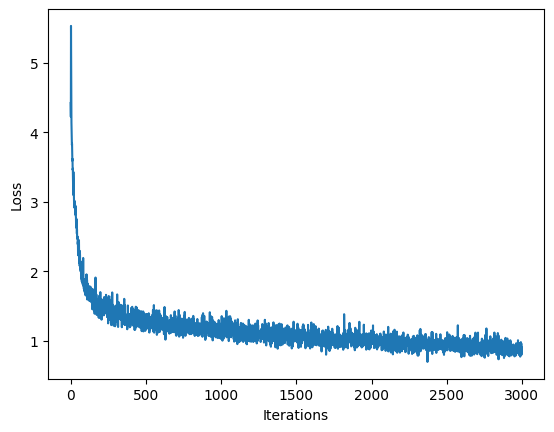

100%|██████████| 3000/3000 [17:47<00:00,  2.81it/s]


True

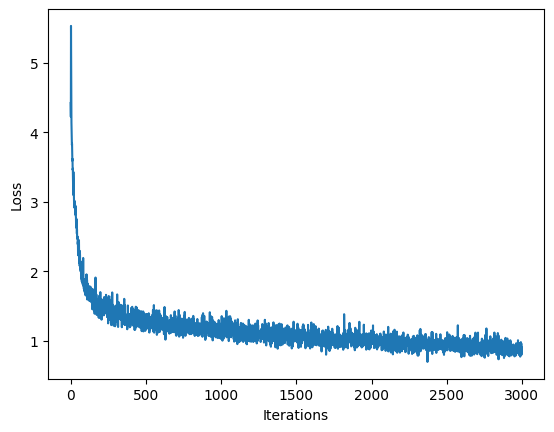

In [ ]:
### Mendefinisikan Optimizer dan Operasi Pelatihan ###

'''TODO: buat instance model baru untuk pelatihan menggunakan fungsi `build_model`
  serta hiperparameter yang telah didefinisikan di atas.'''
model = build_model(vocab_size, params["____"], params["____"], params["____"]) #TODO (10)

'''TODO: buat instance optimizer beserta nilai learning rate-nya.
  Lihat situs resmi TensorFlow untuk daftar optimizer yang didukung:
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Cobalah menggunakan Adam optimizer sebagai permulaan.'''
optimizer = tf.keras.optimizers.Adam(params["____"]) # optimizer = # TODO (5)


@tf.function
def train_step(x, y):
  # Gunakan tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: masukkan input saat ini ke dalam model dan hasilkan prediksi'''
    y_hat = model(____) # TODO (10)

    '''TODO: hitung nilai loss!'''
    loss = compute_loss(____, ____) # TODO (10)

  # Sekarang, hitung gradien
  '''TODO: lengkapi pemanggilan fungsi untuk menghitung gradien.
      Ingat bahwa gradien yang dihitung adalah gradien loss terhadap
      seluruh parameter model.
      PETUNJUK: gunakan `model.trainable_variables` untuk mendapatkan
      daftar semua parameter model.'''
  grads = tape.gradient(____, ____) # TODO (10)

  # Terapkan gradien pada optimizer agar bobot model dapat diperbarui
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Mulai Pelatihan!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # hapus jika sudah ada
for iter in tqdm(range(params["num_training_iterations"])):

  # Ambil satu batch dan propagasikan melalui jaringan
  x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
  loss = train_step(x_batch, y_batch)

  # Catat nilai loss ke antarmuka Comet agar dapat dilacak
  experiment.log_metric("loss", loss.numpy().mean(), step=iter)
  
  # Perbarui progress bar sekaligus visualisasi dalam notebook
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Simpan bobot model secara berkala
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Simpan model yang sudah dilatih beserta bobotnya
model.save_weights(checkpoint_prefix)
experiment.flush()


## 2.6 Menghasilkan Musik Menggunakan Model RNN

Sekarang, kita dapat menggunakan model RNN yang telah dilatih untuk menghasilkan musik!  
Dalam proses menghasilkan musik, kita perlu memberikan model sebuah *seed* sebagai titik awal (karena model tidak dapat memprediksi apa pun tanpa input awal).  

Setelah memiliki *seed* tersebut, kita kemudian dapat secara iteratif memprediksi setiap karakter berikutnya (ingat, kita menggunakan representasi ABC untuk musik). Lebih spesifiknya, perlu diingat bahwa RNN menghasilkan keluaran berupa `softmax` atas kemungkinan karakter selanjutnya. Untuk keperluan *inference*, kita melakukan *sampling* secara iteratif dari distribusi tersebut, lalu menggunakan hasil *sampling* untuk menyusun sebuah lagu dalam format ABC.  

Langkah terakhir adalah menuliskannya ke dalam sebuah berkas dan mendengarkannya!


### Memulihkan Checkpoint Terbaru

Untuk menyederhanakan langkah *inference* ini, kita akan menggunakan ukuran *batch* sebesar 1.  
Karena cara RNN meneruskan *state* dari satu *timestep* ke *timestep* berikutnya, model hanya dapat menerima ukuran *batch* yang tetap setelah dibangun.  

Untuk menjalankan model dengan `batch_size` yang berbeda, kita perlu membangun ulang model dan memulihkan bobot dari *checkpoint* terbaru, yaitu bobot setelah *checkpoint* terakhir selama proses pelatihan.


In [ ]:
'''TODO: Bangun ulang model dengan batch_size=1'''
model = build_model(vocab_size, params["____"], params["____"], batch_size=1) # TODO (10)

# Pulihkan bobot model dari checkpoint terakhir setelah pelatihan
model.build(tf.TensorShape([1, None]))
model.load_weights(checkpoint_prefix)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, None, 256)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (1, None, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, None, 83)          │        85,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

Perhatikan bahwa kita telah memberikan `batch_size` tetap sebesar 1 untuk proses *inference*.


### Prosedur Prediksi

Sekarang, kita siap menulis kode untuk menghasilkan teks dalam format musik ABC:

* Inisialisasi string awal sebagai *seed* dan state RNN, serta tentukan jumlah karakter yang ingin kita hasilkan.

* Gunakan string awal dan state RNN untuk memperoleh distribusi probabilitas atas karakter berikutnya yang diprediksi.

* Lakukan *sampling* dari distribusi multinomial untuk menghitung indeks dari karakter yang diprediksi. Karakter hasil prediksi ini kemudian digunakan sebagai input berikutnya ke model.

* Pada setiap langkah waktu (*time step*), state RNN yang telah diperbarui dimasukkan kembali ke dalam model, sehingga model memiliki lebih banyak konteks dalam membuat prediksi selanjutnya. Setelah memprediksi karakter berikutnya, state RNN yang telah diperbarui kembali dimasukkan ke dalam model. Inilah cara model mempelajari ketergantungan urutan dalam data, karena ia mendapatkan lebih banyak informasi dari prediksi sebelumnya.

![LSTM inference](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab1/img/lstm_inference.png)

Lengkapi dan bereksperimenlah dengan blok kode ini (serta beberapa aspek dari definisi jaringan dan pelatihan!), lalu amati bagaimana kinerja model. Bagaimana perbandingan lagu yang dihasilkan setelah pelatihan dengan jumlah epoch yang sedikit dibandingkan dengan pelatihan dalam durasi lebih lama?


In [ ]:
### Prediksi sebuah lagu yang dihasilkan ###

def generate_text(model, start_string, generation_length=1000, temperature=1.0):
    """
    Menghasilkan teks ABC dari model RNN yang sudah dilatih.

    Args:
        model: model tf.keras yang menghasilkan logits atas kosakata.
        start_string: string awal sebagai seed (misalnya, "X").
        generation_length: jumlah karakter baru yang ingin dihasilkan.
        temperature: suhu sampling (>0). Semakin rendah = semakin greedy.

    Membutuhkan dictionary global:
        char2idx: {karakter -> int}
        idx2char: np.array/list mapping int -> karakter
    """

    # 1) Vektorisasi seed
    input_eval = tf.expand_dims([char2idx[c] for c in start_string], 0)  # bentuk [1, panjang_seed]

    # 2) Reset state jika model memiliki lapisan RNN stateful
    for layer in getattr(model, "layers", []):
        if hasattr(layer, "reset_states"):
            layer.reset_states()

    text_generated = []

    # 3) Loop generasi
    tqdm._instances.clear()
    for _ in tqdm(range(generation_length)):
        # Forward pass: logits atas vocab untuk setiap time step dalam sequence
        logits = model(input_eval)                  # [1, T, vocab] atau [1, vocab] tergantung model
        if logits.shape.rank == 3:
            logits = logits[:, -1, :]               # ambil time step terakhir -> [1, vocab]

        # Sampling token berikutnya dari distribusi kategorikal (logits / temperature)
        logits = logits / max(temperature, 1e-6)    # hindari pembagian dengan nol
        next_id = tf.random.categorical(logits, num_samples=1)[-1, 0].numpy()

        # Tambahkan karakter hasil prediksi
        text_generated.append(idx2char[next_id])

        # Input berikutnya adalah id hasil prediksi (batch size = 1)
        input_eval = tf.expand_dims([next_id], 0)

    return start_string + "".join(text_generated)


In [ ]:
'''TODO: Gunakan model dan fungsi yang telah didefinisikan di atas untuk menghasilkan teks format ABC dengan panjang 1000!
    Seperti yang mungkin kamu perhatikan, file ABC selalu diawali dengan "X" - ini bisa menjadi start string yang bagus.'''
generated_text = generate_text(____, start_string="X", generation_length=1000) # TODO (5)

100%|██████████| 1000/1000 [00:10<00:00, 93.82it/s]


In [32]:
generate_text

<function __main__.generate_text(model, start_string, generation_length=1000, temperature=1.0)>

### Putar musik yang dihasilkan!  

Sekarang kita dapat memanggil sebuah fungsi untuk mengonversi teks dalam format ABC menjadi file audio, lalu memutarnya kembali untuk mendengarkan musik yang telah dihasilkan!  
Coba latih model lebih lama jika lagu yang dihasilkan terasa kurang panjang, atau lakukan regenerasi lagu!  

Kita juga akan menyimpan lagu tersebut ke Comet -- kamu bisa menemukan lagu-lagu yang tersimpan di halaman `Audio` dan `Assets & Artifacts` pada antarmuka Comet untuk proyek ini.  
Perhatikan dokumentasi [`log_asset()`](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/reference/Experiment/#experimentlog_asset), di mana dijelaskan cara menentukan nama file serta parameter lain untuk menyimpan asetmu.

In [ ]:
### Memutar lagu yang dihasilkan ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Mensintesis gelombang suara dari sebuah lagu
  waveform = mdl.lab1.play_song(song)

  # Jika lagunya valid (sintaks benar), mari kita putar!
  if waveform:
    print("Lagu yang dihasilkan", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # Simpan lagumu ke antarmuka Comet -- kamu bisa mengaksesnya di sana
    experiment.log_asset(wav_file_path)

Found 2 songs in text


In [ ]:
# Ketika sudah selesai, akhiri eksperimen comet
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : suspicious_haddock_3197
COMET INFO:     url                   : https://www.comet.com/tokseka-uajy/6s191-lab1-part2/27b93f0b7f7b42a7b024d3794945553f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3000] : (0.6995535492897034, 5.527125358581543)
COMET INFO:   Parameters:
COMET INFO:     batch_size              : 8
COMET INFO:     embedding_dim           : 256
COMET INFO:     learning_rate           : 0.005
COMET INFO:     num_training_iterations : 3000
COMET INFO:     rnn_units               : 1024
COMET INFO:     seq_length              : 100
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename      